In [34]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


In [35]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [36]:
# import the necessary Library

import segmentation_models as sm
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf    
import keras
from keras.callbacks import EarlyStopping
from keras.models import Model,load_model
from sklearn.model_selection import train_test_split

Segmentation Models: using `tf.keras` framework.


* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [37]:
# Setting framework environment
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing

In [38]:
H = 480 # height of image
W = 480 # width of image  


# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks


# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x


# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset


# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

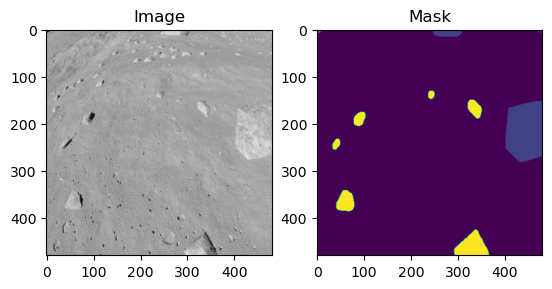

In [39]:
# define file paths for image and mask
image_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0002.png'
mask_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0002.png'

# define a function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

# define a function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

# read the image and mask
image = read_image(image_path)
mask = read_mask(mask_path)

# display the image and mask side by side
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(mask)
axs[1].set_title('Mask')
plt.show()

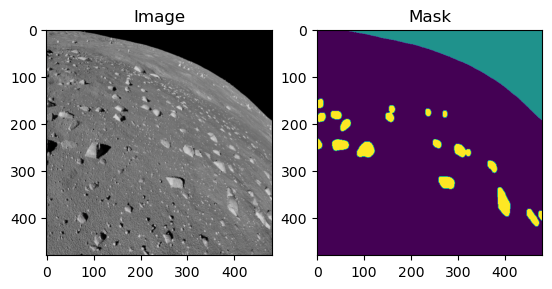

In [40]:
# define file paths for image and mask
image_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0014.png'
mask_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0014.png'

# define a function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

# define a function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

# read the image and mask
image = read_image(image_path)
mask = read_mask(mask_path)

# display the image and mask side by side
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(mask)
axs[1].set_title('Mask')
plt.show()

In [41]:

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [42]:
batch_size = 16 

# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture

Here we are going to use transfer learning to build U-net architecture using Vgg-16 backbone.

><u>Transfer Leranring</u>: Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

In [43]:

#Creating a base model 
IMG_SHAPE = (480, 480, 3)

# include_top specify that we don't want to use the top layer (classifier)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base

base_model.trainable = False


base_model.summary()

#Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# head layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 240, 128)     147584    
                                                              

In [44]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'


'''segmentation_model basically will create a mirror image of our backbone as expansion path and 
add to the contraction path'''
model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 480, 480, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 480, 480, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

## Load model and compile

In [53]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #importing the necessary modules for callbacks
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3)  
num_classes = 4
lr = 1e-5 #decreased learning rate gives better generalization
batch_size = 16 #increasing the batch size can provide better performance
epochs = 30 #Increased epochs give better scores

# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8),
               metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


""" Callbacks """

current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.h5', monitor='val_iou_score', verbose=1, mode='max', 
                                           save_best_only=True), 
             
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, 
        verbose=1, min_lr=1e-6), #this callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, 
          #the learning rate is reduced.
    
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),
        #Stop training when a monitored metric has stopped improving.
]

## Train model

In [98]:
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
        )

Epoch 1/30
488/488 [==============================] - 395s 807ms/step - loss: 0.7925 - iou_score: 0.0467 - f1-score: 0.0756 - val_loss: 0.5849 - val_iou_score: 0.3459 - val_f1-score: 0.1643

Epoch 00001: val_iou_score improved from -inf to 0.3459, saving model to models/LunarModel.h5

Epoch 2/30
488/488 [==============================] - 389s 798ms/step - loss: 0.5418 - iou_score: 0.1450 - f1-score: 0.1810 - val_loss: 0.4564 - val_iou_score: 0.36012 - val_f1-score: 0.2163

Epoch 00002: val_iou_score improved from 0.3459 to 0.36012, saving model to models/LunarModel.h5

Epoch 3/30
488/488 [==============================] - 389s 797ms/step - loss: 0.3749 - iou_score: 0.2233 - f1-score: 0.2359 - val_loss: 0.3234 - val_iou_score: 0.37895 - val_f1-score: 0.2458

Epoch 00003: val_iou_score improved from 0.3459 to 0.37895, saving model to models/LunarModel.h5

Epoch 4/30
488/488 [==============================] - 389s 798ms/step - loss: 0.2824 - iou_score: 0.3170 - f1-score: 0.3235 - val_loss

In [58]:
model.save('Lunarmodel83')

## Output the images using final model.

In [59]:
model = load_model('/kaggle/input/final-lunar-model/FinaleLunarModel.h5',compile=False)

In [60]:
from skimage.io import imread
from skimage.transform import resize

# function to predict result 
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]
    
    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    

    return img, mask, pred_mask

1/1 [==============================] - 2s 2s/step


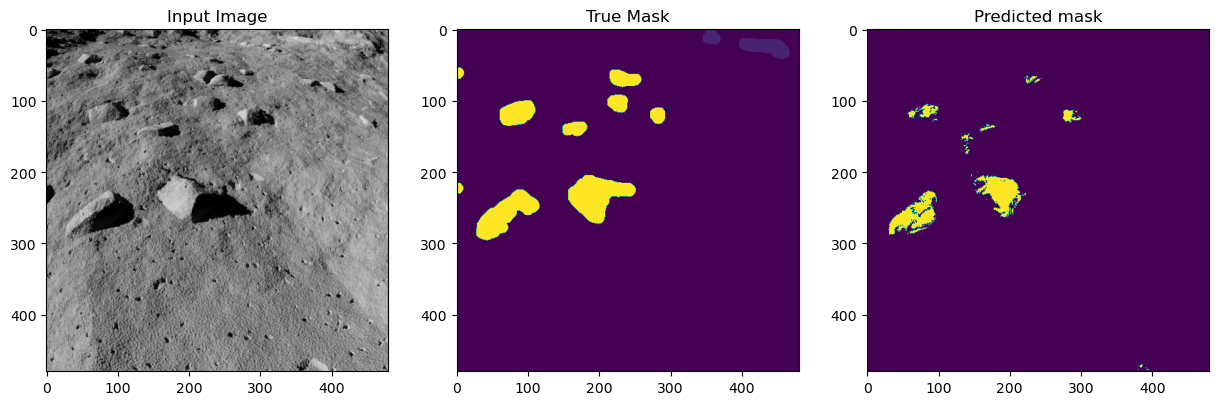

In [90]:
img_path = '../input/artificial-lunar-rocky-landscape-dataset/images/render/render0327.png'
mask_path = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0327.png'

img, mask, pred_mask = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask")
ax3.imshow(pred_mask)

plt.savefig("image327.png")
plt.show()

1/1 [==============================] - 1s 1s/step


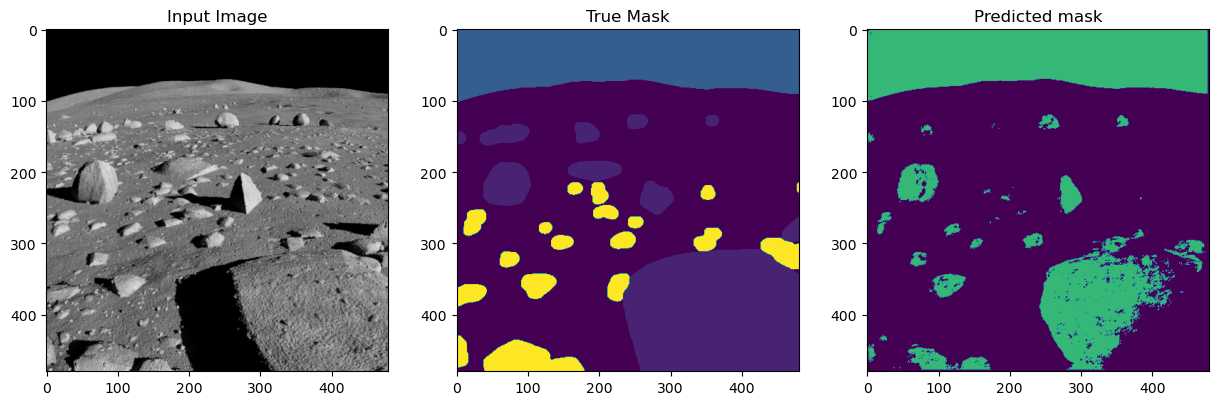

In [91]:
img_path = '../input/artificial-lunar-rocky-landscape-dataset/images/render/render0042.png'
mask_path = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0042.png'

img, mask, pred_mask = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask")
ax3.imshow(pred_mask)

plt.savefig("image042.png")
plt.show()

## Custom Images to predict ( Model unseen images )

custom image path : /kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images

In [92]:
from skimage.io import imread
from skimage.transform import resize
import cv2 as cv

# function to predict result 
def predict_image(img_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    img = img[:, :, :3]
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)
    
    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    
    return img,pred_mask

1/1 [==============================] - 1s 1s/step


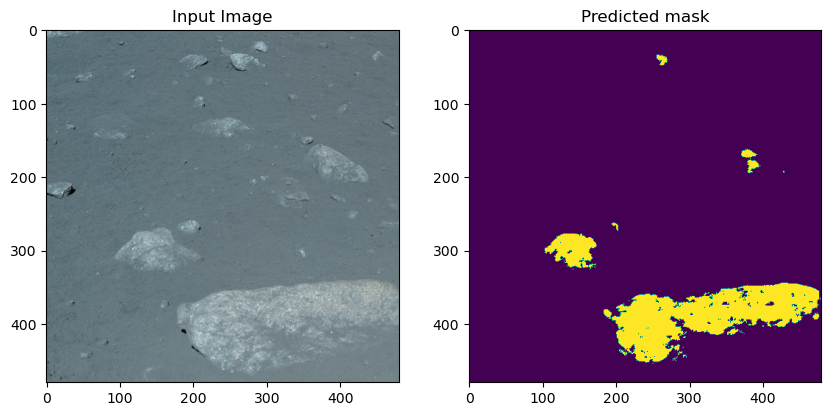

In [94]:
img_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/PCAM1.png'

img, pred_mask = predict_image(img_path, model)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("Predicted mask")
ax2.imshow(pred_mask)

plt.savefig("PCAM1.png")

plt.show()

1/1 [==============================] - 1s 1s/step


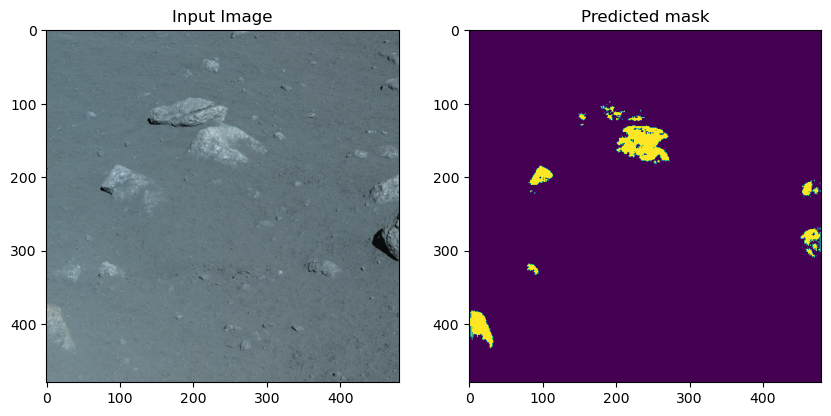

In [95]:
img_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/PCAM3.png'

img, pred_mask = predict_image(img_path, model)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("Predicted mask")
ax2.imshow(pred_mask)

plt.savefig("PCAM3.png")

plt.show()

1/1 [==============================] - 1s 1s/step


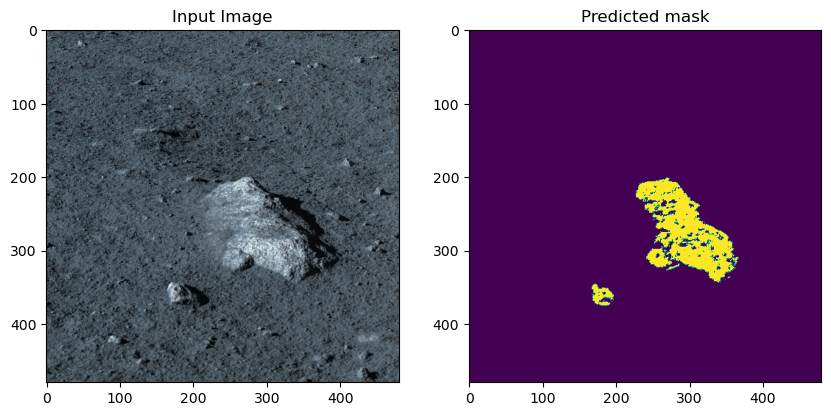

In [96]:
img_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/PCAM8.png'

img, pred_mask = predict_image(img_path, model)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("Predicted mask")
ax2.imshow(pred_mask)

plt.savefig("PCAM8.png")

plt.show()

1/1 [==============================] - 1s 1s/step


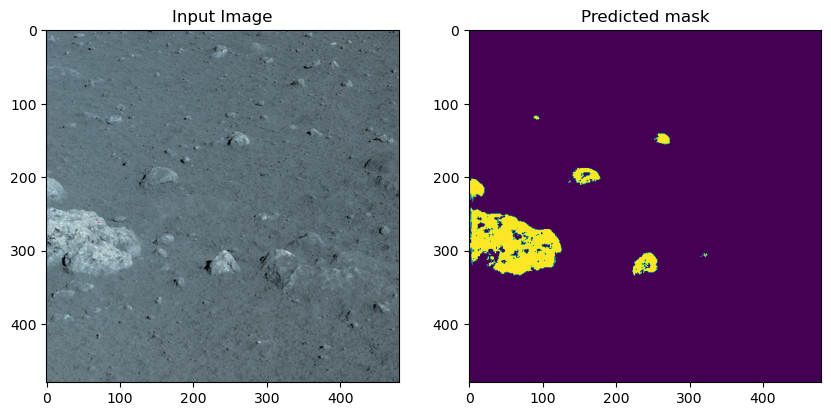

In [97]:
img_path = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/PCAM12.png'

img, pred_mask = predict_image(img_path, model)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("Predicted mask")
ax2.imshow(pred_mask)

plt.savefig("PCAM12.png")

plt.show()

# Documentation and plottings

In [100]:

history_1 = {'loss': [0.5254549384117126, 0.3412989675998688, 0.2487601637840271, 0.1812313199043274, 0.1368768811225891], 'iou_score': [0.11965442448854446, 0.14698687195777893, 0.1626971960067749, 0.17552980780601501, 0.18463236093521118], 'val_loss': [0.37975144386291504, 0.2783949375152588, 0.20656761527061462, 0.1613922119140625, 0.13200326263904572], 'val_iou_score': [0.13717593252658844, 0.1569286435842514, 0.1707352250814438, 0.17854911088943481, 0.1882665604352951]}

history_2 = {'loss': [0.7117266654968262, 0.45600977540016174, 0.32547199726104736, 0.2279183566570282, 0.16186082363128662, 0.11996787786483765, 0.11696285754442215, 0.0921688973903656, 0.0718517005443573, 0.05767085403203964], 'iou_score': [0.09559328854084015, 0.1265251636505127, 0.14856009185314178, 0.16742736101150513, 0.181313157081604, 0.19015181064605713, 0.18565881252288818, 0.19315171241760254, 0.1987294852733612, 0.20289762318134308], 'val_loss': [0.535325825214386, 0.3988516330718994, 0.2590702772140503, 0.18397140502929688, 0.13768278062343597, 0.09571881592273712, 0.1234917938709259, 0.07880087196826935, 0.06533107906579971, 0.05109025910496712], 'val_iou_score': [0.11426077783107758, 0.13529102504253387, 0.16133055090904236, 0.176660418510437, 0.18747836351394653, 0.17860347032546997, 0.19018268585205078, 0.19373475015163422, 0.19897028803825378, 0.20525702834129333]}

history_3 = {'loss': [0.5231246948242188, 0.29555752873420715, 0.1906273365020752, 0.1472758799791336, 0.11205197125673294, 0.10782746225595474, 0.08973213285207748, 0.0702207162976265, 0.05447293072938919, 0.045201513916254044, 0.03672035038471222, 0.03309774026274681, 0.028841398656368256, 0.026001188904047012, 0.023984219878911972, 0.02635415643453598, 0.026804916560649872, 0.02383970469236374, 0.020823553204536438, 0.01983710378408432, 0.018271274864673615, 0.017161225900053978, 0.01563640683889389, 0.01541261188685894, 0.0139857716858387], 'iou_score': [0.1243908479809761, 0.16222189366817474, 0.1833956390619278, 0.1921129673719406, 0.19765444099903107, 0.1907443106174469, 0.19514665007591248, 0.200332909822464, 0.2048458606004715, 0.207950621843338, 0.21014545857906342, 0.21085435152053833, 0.21234752237796783, 0.21192960441112518, 0.21221977472305298, 0.20339864492416382, 0.20455610752105713, 0.20718446373939514, 0.20775827765464783, 0.20810995995998383, 0.20792241394519806, 0.20899656414985657, 0.20883379876613617, 0.20895922183990479, 0.20606213808059692], 'val_loss': [0.3504341244697571, 0.2270856350660324, 0.15799111127853394, 0.12615768611431122, 0.1073581874370575, 0.09883617609739304, 0.07801088690757751, 0.05247480422258377, 0.045154619961977005, 0.03397982940077782, 0.038976382464170456, 0.025591908022761345, 0.023734865710139275, 0.030592909082770348, 0.022325491532683372, 0.025612615048885345, 0.026377787813544273, 0.020990507677197456, 0.03191310167312622, 0.015842529013752937, 0.015667308121919632, 0.026735998690128326, 0.014911118894815445, 0.014886182732880116, 0.01278657466173172], 'val_iou_score': [0.1469690501689911, 0.17493127286434174, 0.19046643376350403, 0.19754275679588318, 0.196194589138031, 0.1899973303079605, 0.1984904706478119, 0.20007845759391785, 0.20677940547466278, 0.20857937633991241, 0.20819391310214996, 0.2120230495929718, 0.21219679713249207, 0.21205317974090576, 0.21221648156642914, 0.19799432158470154, 0.20467513799667358, 0.20470266044139862, 0.2034219652414322, 0.20694592595100403, 0.20698517560958862, 0.20529471337795258, 0.20798468589782715, 0.20643728971481323, 0.20589295029640198]}

history_4 = {'loss': [0.43286043405532837, 0.2720092535018921, 0.20550419390201569, 0.16345758736133575, 0.12861192226409912, 0.11693187803030014, 0.11703502386808395, 0.1101461723446846, 0.09524888545274734, 0.08133452385663986, 0.07763978838920593, 0.07429588586091995, 0.06552217900753021, 0.05563415214419365, 0.04448946937918663, 0.0377994179725647, 0.03220848739147186, 0.028843320906162262, 0.026018496602773666, 0.023074179887771606, 0.021483756601810455, 0.019931970164179802, 0.01835424266755581, 0.017356084659695625, 0.015776950865983963, 0.016650449484586716, 0.021920375525951385, 0.023347102105617523, 0.020344719290733337, 0.018535394221544266, 0.017241302877664566, 0.015975872054696083, 0.015211859717965126, 0.014745913445949554, 0.014037104323506355, 0.013343127444386482, 0.012828712351620197, 0.012593723833560944, 0.011909034103155136, 0.011844292283058167, 0.011635417118668556, 0.01096460409462452, 0.01081845909357071, 0.010910299606621265, 0.010522273369133472, 0.010119175538420677, 0.00968517642468214, 0.00988337304443121, 0.009502183645963669, 0.009452028200030327], 'iou_score': [0.1380644142627716, 0.1628788560628891, 0.1776314377784729, 0.18744289875030518, 0.19564461708068848, 0.19577080011367798, 0.19281889498233795, 0.19239701330661774, 0.19341067969799042, 0.19471125304698944, 0.1946040242910385, 0.19352731108665466, 0.1949586719274521, 0.1985033005475998, 0.2014687955379486, 0.20285485684871674, 0.20450548827648163, 0.20504659414291382, 0.2066250443458557, 0.2061537653207779, 0.20712536573410034, 0.2073480784893036, 0.2081790417432785, 0.207839235663414, 0.20787252485752106, 0.20082062482833862, 0.19586464762687683, 0.1980830729007721, 0.1998003125190735, 0.19976143538951874, 0.20048119127750397, 0.20061273872852325, 0.20064498484134674, 0.2013738751411438, 0.2011544108390808, 0.2011726349592209, 0.20187801122665405, 0.20123229920864105, 0.20211051404476166, 0.2014688104391098, 0.20192614197731018, 0.20226441323757172, 0.2017780840396881, 0.20251692831516266, 0.20190419256687164, 0.20287074148654938, 0.20263808965682983, 0.20259210467338562, 0.20267267525196075, 0.2030162513256073], 'val_loss': [0.3060072660446167, 0.2395060658454895, 0.1761082261800766, 0.17378093302249908, 0.10429279506206512, 0.111778125166893, 0.10540833324193954, 0.11946316063404083, 0.07873685657978058, 0.07291625440120697, 0.08253438025712967, 0.0778992623090744, 0.05734667181968689, 0.0424986407160759, 0.045263394713401794, 0.034862495958805084, 0.027595985680818558, 0.028429633006453514, 0.030050696805119514, 0.02977176383137703, 0.01606934331357479, 0.017765456810593605, 0.020077552646398544, 0.013626025058329105, 0.019243694841861725, 0.017749212682247162, 0.02026374265551567, 0.019344815984368324, 0.014957351610064507, 0.014733126387000084, 0.026107214391231537, 0.01795090176165104, 0.01644757390022278, 0.01213210728019476, 0.01399934757500887, 0.012668750248849392, 0.013084023259580135, 0.018012898042798042, 0.01058515440672636, 0.010186471976339817, 0.01122604962438345, 0.009914153255522251, 0.010188835673034191, 0.011326152831315994, 0.010078204795718193, 0.014753025025129318, 0.011425738222897053, 0.011663046665489674, 0.02575257048010826, 0.009018166922032833], 'val_iou_score': [0.15508875250816345, 0.1738874763250351, 0.1870644986629486, 0.19103974103927612, 0.19934578239917755, 0.19723312556743622, 0.1927209049463272, 0.19034183025360107, 0.1944122016429901, 0.1972360610961914, 0.19195368885993958, 0.19093334674835205, 0.19459809362888336, 0.19902393221855164, 0.19864872097969055, 0.2017960101366043, 0.20471909642219543, 0.20454718172550201, 0.20509852468967438, 0.20350974798202515, 0.20641197264194489, 0.20637358725070953, 0.20681029558181763, 0.20737609267234802, 0.20777243375778198, 0.196681410074234, 0.19398850202560425, 0.19681796431541443, 0.19713085889816284, 0.1981908679008484, 0.1972302496433258, 0.19943498075008392, 0.19964829087257385, 0.19996923208236694, 0.20052969455718994, 0.20154990255832672, 0.19843357801437378, 0.19997064769268036, 0.2005576491355896, 0.20230022072792053, 0.20011763274669647, 0.20034167170524597, 0.2017102837562561, 0.2020622044801712, 0.20082782208919525, 0.2007213830947876, 0.20169804990291595, 0.20173420011997223, 0.19886332750320435, 0.20218771696090698]}

history_5 = {'loss': [0.5102024078369141, 0.3808255195617676, 0.342494934797287, 0.311972051858902, 0.2863192558288574, 0.2621672451496124, 0.24492156505584717, 0.2295733243227005, 0.21743345260620117, 0.20175980031490326, 0.19247595965862274, 0.18765093386173248, 0.18088099360466003, 0.1699109524488449, 0.16155090928077698, 0.15344645082950592, 0.1452411413192749, 0.13695180416107178, 0.12918643653392792, 0.12343230843544006, 0.11427398025989532, 0.11209619045257568, 0.10334597527980804, 0.09763988107442856, 0.09234745800495148, 0.08627307415008545, 0.08234837651252747, 0.07715348154306412, 0.07279873639345169, 0.06969960033893585, 0.06629111617803574, 0.06323347985744476, 0.06017577648162842, 0.057994455099105835, 0.05530703812837601, 0.051972631365060806, 0.050066690891981125, 0.04775450378656387, 0.04592465981841087, 0.0439772754907608, 0.04198842868208885, 0.04081432521343231, 0.03984374925494194, 0.03676902502775192, 0.03610169515013695, 0.035311710089445114, 0.03384444862604141, 0.0336664617061615, 0.03249666467308998, 0.03101402148604393], 'iou_score': [0.12166621536016464, 0.1407739669084549, 0.14636902511119843, 0.1510908305644989, 0.1559946984052658, 0.16013501584529877, 0.1633060872554779, 0.1664399951696396, 0.16857005655765533, 0.17108242213726044, 0.17263959348201752, 0.17204329371452332, 0.1721697896718979, 0.173943892121315, 0.1758764088153839, 0.1775413453578949, 0.1793416142463684, 0.1805041879415512, 0.1822650134563446, 0.18323563039302826, 0.18447186052799225, 0.1860828548669815, 0.1871851086616516, 0.18871167302131653, 0.18982377648353577, 0.19103163480758667, 0.19204144179821014, 0.19331081211566925, 0.1942155361175537, 0.1954493671655655, 0.19743646681308746, 0.19890424609184265, 0.20067401230335236, 0.20181098580360413, 0.20295237004756927, 0.20278602838516235, 0.2037133425474167, 0.20417049527168274, 0.20449784398078918, 0.20522348582744598, 0.20529404282569885, 0.20589317381381989, 0.20599313080310822, 0.20652642846107483, 0.20690487325191498, 0.20662611722946167, 0.2068103849887848, 0.20695731043815613, 0.2073846310377121, 0.2074553519487381], 'val_loss': [0.39725029468536377, 0.369651734828949, 0.33915477991104126, 0.2991711497306824, 0.2752697765827179, 0.2532455027103424, 0.23558400571346283, 0.22332285344600677, 0.20665243268013, 0.19314906001091003, 0.19083228707313538, 0.1853574514389038, 0.17151376605033875, 0.1655317097902298, 0.15427003800868988, 0.14949224889278412, 0.14130164682865143, 0.13011261820793152, 0.12491822987794876, 0.11641743034124374, 0.11111120879650116, 0.1046392023563385, 0.09700681269168854, 0.09426221996545792, 0.08438940346240997, 0.07954064011573792, 0.07568871229887009, 0.0742909386754036, 0.07055303454399109, 0.06849515438079834, 0.06429896503686905, 0.06515564769506454, 0.05789819359779358, 0.0531732477247715, 0.0531032420694828, 0.05392197519540787, 0.04666830971837044, 0.044355686753988266, 0.041502635926008224, 0.041317738592624664, 0.04078826680779457, 0.03807447478175163, 0.03637712821364403, 0.0346815288066864, 0.03575143218040466, 0.034289050847291946, 0.03085460141301155, 0.02938637137413025, 0.02843034453690052, 0.028198935091495514], 'val_iou_score': [0.13821634650230408, 0.14384981989860535, 0.14728198945522308, 0.15388648211956024, 0.15821336209774017, 0.16279186308383942, 0.1651902049779892, 0.16778111457824707, 0.17044216394424438, 0.17285959422588348, 0.1738942712545395, 0.17178276181221008, 0.17467272281646729, 0.1749056726694107, 0.1778213530778885, 0.17967171967029572, 0.1799134463071823, 0.18201421201229095, 0.18332384526729584, 0.18499749898910522, 0.185831218957901, 0.1862829029560089, 0.18756546080112457, 0.18865129351615906, 0.19108611345291138, 0.19245123863220215, 0.1924789398908615, 0.1933971643447876, 0.19515734910964966, 0.19655124843120575, 0.19930429756641388, 0.19956862926483154, 0.20107555389404297, 0.2026698887348175, 0.20290528237819672, 0.20376071333885193, 0.20390735566616058, 0.2046898454427719, 0.2058342546224594, 0.2060648798942566, 0.20620912313461304, 0.20519010722637177, 0.20734098553657532, 0.20711630582809448, 0.20721940696239471, 0.2070866823196411, 0.20758609473705292, 0.20715589821338654, 0.2081596553325653, 0.20833563804626465]}

history_6 = {'loss': [0.22441129386425018, 0.08437145501375198, 0.04810270294547081, 0.036801546812057495, 0.02931506745517254, 0.024750476703047752, 0.02008216641843319, 0.01715734414756298, 0.015079359523952007, 0.013089154846966267, 0.0116874473169446, 0.01129483338445425, 0.009966034442186356, 0.008590109646320343, 0.008808339945971966, 0.008795803412795067, 0.007681146264076233, 0.006718507036566734, 0.006955177057534456, 0.00918428786098957, 0.007796969264745712, 0.007146245799958706, 0.006463531404733658, 0.006052994169294834, 0.00553742703050375, 0.005131763871759176, 0.004615921061486006, 0.0041485922411084175, 0.006298393476754427, 0.007640054915100336], 'iou_score': [0.1711062639951706, 0.20042046904563904, 0.20869573950767517, 0.20480075478553772, 0.19937124848365784, 0.19781453907489777, 0.199489563703537, 0.20006175339221954, 0.20025542378425598, 0.20069590210914612, 0.1962157040834427, 0.19613897800445557, 0.19687584042549133, 0.1964382827281952, 0.19226773083209991, 0.19329948723316193, 0.19365264475345612, 0.19384226202964783, 0.1911192089319229, 0.1903240978717804, 0.1913575679063797, 0.1913963407278061, 0.1917920559644699, 0.19196674227714539, 0.19218562543392181, 0.1925208419561386, 0.19259092211723328, 0.19274762272834778, 0.19077016413211823, 0.19032232463359833], 'val_loss': [0.11356732249259949, 0.05444024130702019, 0.03845363110303879, 0.02629009261727333, 0.024184897541999817, 0.025789812207221985, 0.01657487452030182, 0.016436666250228882, 0.010876035317778587, 0.015326960943639278, 0.012228039093315601, 0.009516128338873386, 0.008705141954123974, 0.008383819833397865, 0.00807191152125597, 0.007130199111998081, 0.013432868756353855, 0.007950427941977978, 0.007571718189865351, 0.006958231795579195, 0.00678932573646307, 0.006166970357298851, 0.005966098513454199, 0.006146893836557865, 0.005368188954889774, 0.004553425591439009, 0.00415580440312624, 0.003615193534642458, 0.009651674889028072, 0.006191141437739134], 'val_iou_score': [0.19202178716659546, 0.20783935487270355, 0.2052764892578125, 0.20088033378124237, 0.19784602522850037, 0.19727027416229248, 0.20012322068214417, 0.19889184832572937, 0.19983185827732086, 0.19848275184631348, 0.19392573833465576, 0.19614653289318085, 0.1960635632276535, 0.19380976259708405, 0.19161847233772278, 0.19269603490829468, 0.19114503264427185, 0.19315876066684723, 0.1890287697315216, 0.19023527204990387, 0.19093818962574005, 0.19072438776493073, 0.19157977402210236, 0.19194094836711884, 0.19208145141601562, 0.1920149326324463, 0.1920062005519867, 0.1920596957206726, 0.18822459876537323, 0.19026590883731842]}

history_7 = {'loss': [0.08186221867799759, 0.02125968225300312, 0.018100792542099953, 0.14613975584506989, 0.14829495549201965, 0.13139840960502625, 0.1193615049123764, 0.10924960672855377, 0.10075375437736511, 0.09353817999362946, 0.08699561655521393, 0.08135757595300674, 0.07633999735116959], 'iou_score': [0.19674725830554962, 0.2045295089483261, 0.2027662992477417, 0.16953948140144348, 0.1662207990884781, 0.16958744823932648, 0.1719551682472229, 0.17405007779598236, 0.1758207231760025, 0.17733807861804962, 0.17868009209632874, 0.17987126111984253, 0.18094168603420258], 'val_loss': [0.021308284252882004, 0.012292802333831787, 0.010381177999079227, 0.1743612289428711, 0.14683492481708527, 0.12148582190275192, 0.11423883587121964, 0.11329975724220276, 0.09572690725326538, 0.09188910573720932, 0.07185018807649612, 0.08710998296737671, 0.08491721004247665], 'val_iou_score': [0.19325916469097137, 0.19800803065299988, 0.1959214061498642, 0.15824702382087708, 0.16435961425304413, 0.17032311856746674, 0.17307724058628082, 0.17343758046627045, 0.1756078153848648, 0.1777110993862152, 0.18039003014564514, 0.17996156215667725, 0.17772965133190155]}

history_8 = {'loss': [0.07765202224254608, 0.04012763872742653, 0.02456658147275448, 0.4974954426288605, 0.3394964039325714], 'iou_score': [0.21540233492851257, 0.21004462242126465, 0.20592689514160156, 0.10284782201051712, 0.18557944893836975], 'f1-score': [0.23038724064826965, 0.2278778851032257, 0.22548066079616547, 0.12334077060222626, 0.21213017404079437], 'val_loss': [0.2353668510913849, 0.08914081752300262, 0.13925518095493317, 0.44899982213974, 0.2575310170650482], 'val_iou_score': [0.1883765012025833, 0.19088131189346313, 0.19058242440223694, 0.14998742938041687, 0.18947358429431915], 'val_f1-score': [0.21465866267681122, 0.21632610261440277, 0.21611249446868896, 0.18721459805965424, 0.2154756337404251], 'lr': [0.0007, 0.0007, 0.0007, 0.0007, 0.0007]}

history_9 = {'loss': [0.25536635518074036, 0.04437649995088577, 0.03212974593043327, 0.02850687876343727, 0.018274173140525818], 'iou_score': [0.36826464533805847, 0.7057791948318481, 0.6297565698623657, 0.5204053521156311, 0.5541524887084961], 'f1-score': [0.3827938735485077, 0.7152298092842102, 0.649531364440918, 0.5456835627555847, 0.5792655944824219], 'val_loss': [0.0813726857304573, 0.032043855637311935, 0.036784738302230835, 0.019282961264252663, 0.023523643612861633], 'val_iou_score': [0.4210038185119629, 0.7208210229873657, 0.6471740007400513, 0.44030866026878357, 0.6841242909431458], 'val_f1-score': [0.42846226692199707, 0.7308229804039001, 0.6729212403297424, 0.46600133180618286, 0.7098129987716675], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

history_10 = {'loss': [0.23851731419563293, 0.04979284852743149, 0.028097860515117645, 0.01984509453177452, 0.01931244693696499, 0.01908903941512108, 0.01335589773952961, 0.011098015122115612], 'iou_score': [0.3502723276615143, 0.942891001701355, 0.9778903126716614, 0.9813889861106873, 0.8599538207054138, 0.7898415327072144, 0.7391858100891113, 0.8353567719459534], 'f1-score': [0.3660469055175781, 0.9557108879089355, 0.9880200028419495, 0.9901788830757141, 0.8827288150787354, 0.8154869675636292, 0.7648126482963562, 0.861030101776123], 'val_loss': [0.09513457119464874, 0.03804868832230568, 0.029048174619674683, 0.013090172782540321, 0.028353895992040634, 0.013774966821074486, 0.011165433563292027, 0.010544698685407639], 'val_iou_score': [0.3710018, 0.3777739, 0.3923279, 0.4003292, 0.4041487, 0.4281143, 0.4298803, 0.4387219, 0.4550053, 0.4980693, 0.5020276, 0.5489299, 0.5623707, 0.5679544, 0.5968884, 0.6202844, 0.6329315, 0.6791537, 0.7169036, 0.7876929, 0.7895362, 0.7895362
], 'val_f1-score': [0.8401544094085693, 0.9660575985908508, 0.9665541648864746, 0.966468334197998, 0.8325780034065247, 0.7220103740692139, 0.9165480136871338, 0.8366550803184509], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-05]}


In [101]:
# visulization code
import matplotlib.pyplot as plt
def Plotting(history1, history2):
        plt.plot(history1['val_iou_score'])
        plt.plot(history2['val_iou_score'])
        plt.title('Model Performance')
        plt.xlabel('epochs')
        plt.ylabel('val_iou_score')
        plt.legend(['Val_iou_score of 1st observation', 'Val_iou_score of 2st observation'])
        plt.show()

In [102]:
# Code block to create tables in Python
# import module
from tabulate import tabulate
def Table_to_compare(history1,history2): 
    # assign data
    mydata = [
        [history1, history2]
    ]

    # create header
    head = ["Before Improvement", "After Improvement"]

    # display table
    print(tabulate(mydata, headers=head, tablefmt="grid"))

# 1. Plotting for impact of epoch increment on basic u-net's val_iou_score

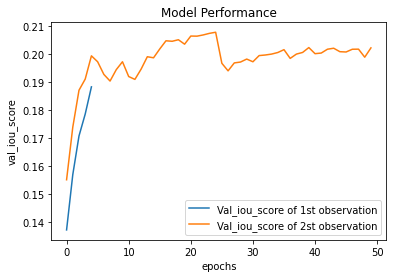



+----------------------+---------------------+

|   Before Improvement |   After Improvement |

+======================+=====================+

|             0.188267 |            0.202188 |

+----------------------+---------------------+



From this comparison of two training runs 1st(history_1) with 5 epochs and 2nd(history_4) one under considration is with 50 epochs it can be seen that there is increase in val_iou_score slightly but it is there. I Didn't increased the number of epochs from 50 as you can see from the graph there is a no real benefit to increasinf the epochs anymore to improve performance


In [72]:
Plotting(history_1,history_4)
print()
Table_to_compare(history_1["val_iou_score"][-1],history_4["val_iou_score"][-1])
print("\nFrom this comparison of two training runs 1st(history_1) with 5 epochs and 2nd(history_4) one under considration is with 50 epochs it can be seen that there is increase in val_iou_score slightly but it is there. I Didn't increased the number of epochs from 50 as you can see from the graph there is a no real benefit to increasinf the epochs anymore to improve performance")

# 2. Plotting for impact of learning rate decrement on basic u-net's val_iou_score

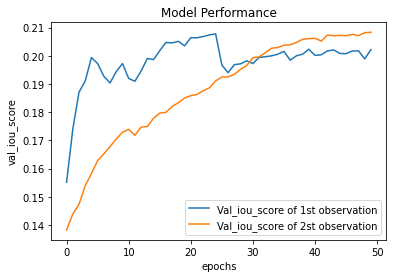



+----------------------+---------------------+

|   Before Improvement |   After Improvement |

+======================+=====================+

|             0.202188 |            0.208336 |

+----------------------+---------------------+



As it is evident from the plot there is a stable increase with each epoch with lesser learning rate and also a slight increase in val_iou_score


In [73]:
Plotting(history_4,history_5)
print()
Table_to_compare(history_4["val_iou_score"][-1],history_5["val_iou_score"][-1])
print("\nAs it is evident from the plot there is a stable increase with each epoch with lesser learning rate and also a slight increase in val_iou_score")

# 3. Plotting for impact of using transfer learning technique to build unet on val_iou_score

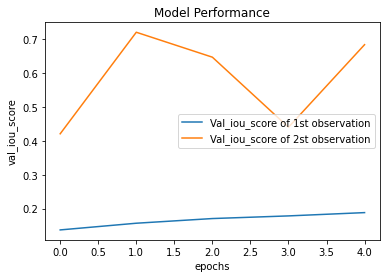



+----------------------+---------------------+

|   Before Improvement |   After Improvement |

+======================+=====================+

|             0.188267 |            0.684124 |

+----------------------+---------------------+



There is great boost in performance by using transfer learning technique to build u-net from a base model Vgg-16, transfer learning is so beneficial that even from the 1st epoch we get a considerable amount of performance as compared to just basic u-net model trained on our dataset.


In [74]:
Plotting(history_1,history_9)
print()
Table_to_compare(history_1["val_iou_score"][-1],history_9["val_iou_score"][-1])
print("\nThere is great boost in performance by using transfer learning technique to build u-net from a base model Vgg-16, transfer learning is so beneficial that even from the 1st epoch we get a considerable amount of performance as compared to just basic u-net model trained on our dataset.")

# 4. Plotting to show impact of inceasing epochs on our updated model

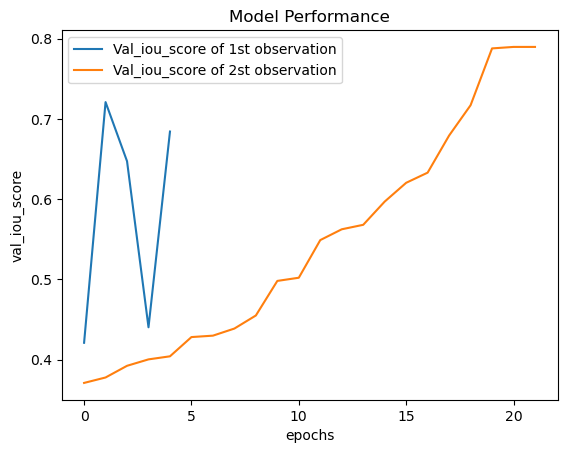


+----------------------+---------------------+
|   Before Improvement |   After Improvement |
+======================+=====================+
|             0.684124 |            0.789536 |
+----------------------+---------------------+


In [104]:
Plotting(history_9,history_10)
print()
Table_to_compare(history_9["val_iou_score"][-1],history_10["val_iou_score"][-1])

# FINAL IMPROVEMENT SUMMARY TABLE

|Experiment# | Description | Increase in val_iou from | Increase in val_iou to (considering val_iou score of final epoch of the corresponding training run) |
|:---| :----: | :---:| :---:|
| 1 | Started at epoch = 5| NA | 0.1882 |
| 2 | Increased epoch = 5, which was given in the deafult notebook to epoch = 10 | 0.1882| 0.2052 |
| 3 | Increased epoch = 10 to epoch = 20 | 0.2052 | 0.2058 |
| 4 | Increased epoch = 20 to epoch = 50 | 0.2058 | 0.2021 |
| 5 | Kept the epoch = 50 as earlier training run but decreased the learning rate of lr = 1e-4 to lr = 1e-5 | 0.2021 | 0.2083 |
| 6 | Tried experimenting with batch size. I used lr = 1e-4, decreased the to batch_size = 8 and used epochs = 30 | 0.2083 | 0.1902 |
| 7 | implemented some callbacks like earlystopping and cmodel checkpointing. Used paramters listed here lr = 7e-4 batch_size = 4 epochs = 30(with early stopped at 13th epoch,because model failed to increase val_iou after 13 epochs) | 0.1902 | 0.1777 |
| 8 | Just used some callbacks and carried out ad-hoc testing of results with the listed parameters lr = 7e-4 batch_size = 16 epochs = 5. No real improvements in results  | 0.1777 | 0.1894 |
| 9 | tranfer learning technique was implemented and tremendous performance increase was attained with the listed parameters, lr = 1e-4 batch_size = 16 epochs = 5.Also, one major change i made in terms of data provided to the model is that i increased the Height and width of the image that is going to be fed to the model as shown in the here(H = 480, W = 480 instead of H,W = 256 ), This was very necessary as lunar dataset had images of 720 * 480 dimensions and as we downscale the H,W values, our model get less pixel data as compared to original image to train on. | 0.1894 | 0.6841 |
| 10 |  increased to epochs = 30 but early stopped after 21 epochs ,in this attempt ,Some parameters that i specified in adam optimizer is epsilon=1e-8. Also used ReducedLRonplateau with min lr = 1e-6 and reduction in lr by factor 0.1 and patience = 5. other than these changes everything is same as previous experiment | 0.6841 | 0.8312 |


# This is collection of model histories of all the experiments that i ran with some characteristics shown along side with it corresponding to that specific training run

### 1st history(epoch = 5):

{'loss': [0.5254549384117126, 0.3412989675998688, 0.2487601637840271, 0.1812313199043274, 0.1368768811225891], 'iou_score': [0.11965442448854446, 0.14698687195777893, 0.1626971960067749, 0.17552980780601501, 0.18463236093521118], 'val_loss': [0.37975144386291504, 0.2783949375152588, 0.20656761527061462, 0.1613922119140625, 0.13200326263904572], 'val_iou_score': [0.13717593252658844, 0.1569286435842514, 0.1707352250814438, 0.17854911088943481, 0.1882665604352951]}

### 2nd history(epoch = 10):

{'loss': [0.7117266654968262, 0.45600977540016174, 0.32547199726104736, 0.2279183566570282, 0.16186082363128662, 0.11996787786483765, 0.11696285754442215, 0.0921688973903656, 0.0718517005443573, 0.05767085403203964], 'iou_score': [0.09559328854084015, 0.1265251636505127, 0.14856009185314178, 0.16742736101150513, 0.181313157081604, 0.19015181064605713, 0.18565881252288818, 0.19315171241760254, 0.1987294852733612, 0.20289762318134308], 'val_loss': [0.535325825214386, 0.3988516330718994, 0.2590702772140503, 0.18397140502929688, 0.13768278062343597, 0.09571881592273712, 0.1234917938709259, 0.07880087196826935, 0.06533107906579971, 0.05109025910496712], 'val_iou_score': [0.11426077783107758, 0.13529102504253387, 0.16133055090904236, 0.176660418510437, 0.18747836351394653, 0.17860347032546997, 0.19018268585205078, 0.19373475015163422, 0.19897028803825378, 0.20525702834129333]}

### 3rd history(epoch = 20):

{'loss': [0.5231246948242188, 0.29555752873420715, 0.1906273365020752, 0.1472758799791336, 0.11205197125673294, 0.10782746225595474, 0.08973213285207748, 0.0702207162976265, 0.05447293072938919, 0.045201513916254044, 0.03672035038471222, 0.03309774026274681, 0.028841398656368256, 0.026001188904047012, 0.023984219878911972, 0.02635415643453598, 0.026804916560649872, 0.02383970469236374, 0.020823553204536438, 0.01983710378408432, 0.018271274864673615, 0.017161225900053978, 0.01563640683889389, 0.01541261188685894, 0.0139857716858387], 'iou_score': [0.1243908479809761, 0.16222189366817474, 0.1833956390619278, 0.1921129673719406, 0.19765444099903107, 0.1907443106174469, 0.19514665007591248, 0.200332909822464, 0.2048458606004715, 0.207950621843338, 0.21014545857906342, 0.21085435152053833, 0.21234752237796783, 0.21192960441112518, 0.21221977472305298, 0.20339864492416382, 0.20455610752105713, 0.20718446373939514, 0.20775827765464783, 0.20810995995998383, 0.20792241394519806, 0.20899656414985657, 0.20883379876613617, 0.20895922183990479, 0.20606213808059692], 'val_loss': [0.3504341244697571, 0.2270856350660324, 0.15799111127853394, 0.12615768611431122, 0.1073581874370575, 0.09883617609739304, 0.07801088690757751, 0.05247480422258377, 0.045154619961977005, 0.03397982940077782, 0.038976382464170456, 0.025591908022761345, 0.023734865710139275, 0.030592909082770348, 0.022325491532683372, 0.025612615048885345, 0.026377787813544273, 0.020990507677197456, 0.03191310167312622, 0.015842529013752937, 0.015667308121919632, 0.026735998690128326, 0.014911118894815445, 0.014886182732880116, 0.01278657466173172], 'val_iou_score': [0.1469690501689911, 0.17493127286434174, 0.19046643376350403, 0.19754275679588318, 0.196194589138031, 0.1899973303079605, 0.1984904706478119, 0.20007845759391785, 0.20677940547466278, 0.20857937633991241, 0.20819391310214996, 0.2120230495929718, 0.21219679713249207, 0.21205317974090576, 0.21221648156642914, 0.19799432158470154, 0.20467513799667358, 0.20470266044139862, 0.2034219652414322, 0.20694592595100403, 0.20698517560958862, 0.20529471337795258, 0.20798468589782715, 0.20643728971481323, 0.20589295029640198]}

### 4th history(epoch = 50):

{'loss': [0.43286043405532837, 0.2720092535018921, 0.20550419390201569, 0.16345758736133575, 0.12861192226409912, 0.11693187803030014, 0.11703502386808395, 0.1101461723446846, 0.09524888545274734, 0.08133452385663986, 0.07763978838920593, 0.07429588586091995, 0.06552217900753021, 0.05563415214419365, 0.04448946937918663, 0.0377994179725647, 0.03220848739147186, 0.028843320906162262, 0.026018496602773666, 0.023074179887771606, 0.021483756601810455, 0.019931970164179802, 0.01835424266755581, 0.017356084659695625, 0.015776950865983963, 0.016650449484586716, 0.021920375525951385, 0.023347102105617523, 0.020344719290733337, 0.018535394221544266, 0.017241302877664566, 0.015975872054696083, 0.015211859717965126, 0.014745913445949554, 0.014037104323506355, 0.013343127444386482, 0.012828712351620197, 0.012593723833560944, 0.011909034103155136, 0.011844292283058167, 0.011635417118668556, 0.01096460409462452, 0.01081845909357071, 0.010910299606621265, 0.010522273369133472, 0.010119175538420677, 0.00968517642468214, 0.00988337304443121, 0.009502183645963669, 0.009452028200030327], 'iou_score': [0.1380644142627716, 0.1628788560628891, 0.1776314377784729, 0.18744289875030518, 0.19564461708068848, 0.19577080011367798, 0.19281889498233795, 0.19239701330661774, 0.19341067969799042, 0.19471125304698944, 0.1946040242910385, 0.19352731108665466, 0.1949586719274521, 0.1985033005475998, 0.2014687955379486, 0.20285485684871674, 0.20450548827648163, 0.20504659414291382, 0.2066250443458557, 0.2061537653207779, 0.20712536573410034, 0.2073480784893036, 0.2081790417432785, 0.207839235663414, 0.20787252485752106, 0.20082062482833862, 0.19586464762687683, 0.1980830729007721, 0.1998003125190735, 0.19976143538951874, 0.20048119127750397, 0.20061273872852325, 0.20064498484134674, 0.2013738751411438, 0.2011544108390808, 0.2011726349592209, 0.20187801122665405, 0.20123229920864105, 0.20211051404476166, 0.2014688104391098, 0.20192614197731018, 0.20226441323757172, 0.2017780840396881, 0.20251692831516266, 0.20190419256687164, 0.20287074148654938, 0.20263808965682983, 0.20259210467338562, 0.20267267525196075, 0.2030162513256073], 'val_loss': [0.3060072660446167, 0.2395060658454895, 0.1761082261800766, 0.17378093302249908, 0.10429279506206512, 0.111778125166893, 0.10540833324193954, 0.11946316063404083, 0.07873685657978058, 0.07291625440120697, 0.08253438025712967, 0.0778992623090744, 0.05734667181968689, 0.0424986407160759, 0.045263394713401794, 0.034862495958805084, 0.027595985680818558, 0.028429633006453514, 0.030050696805119514, 0.02977176383137703, 0.01606934331357479, 0.017765456810593605, 0.020077552646398544, 0.013626025058329105, 0.019243694841861725, 0.017749212682247162, 0.02026374265551567, 0.019344815984368324, 0.014957351610064507, 0.014733126387000084, 0.026107214391231537, 0.01795090176165104, 0.01644757390022278, 0.01213210728019476, 0.01399934757500887, 0.012668750248849392, 0.013084023259580135, 0.018012898042798042, 0.01058515440672636, 0.010186471976339817, 0.01122604962438345, 0.009914153255522251, 0.010188835673034191, 0.011326152831315994, 0.010078204795718193, 0.014753025025129318, 0.011425738222897053, 0.011663046665489674, 0.02575257048010826, 0.009018166922032833], 'val_iou_score': [0.15508875250816345, 0.1738874763250351, 0.1870644986629486, 0.19103974103927612, 0.19934578239917755, 0.19723312556743622, 0.1927209049463272, 0.19034183025360107, 0.1944122016429901, 0.1972360610961914, 0.19195368885993958, 0.19093334674835205, 0.19459809362888336, 0.19902393221855164, 0.19864872097969055, 0.2017960101366043, 0.20471909642219543, 0.20454718172550201, 0.20509852468967438, 0.20350974798202515, 0.20641197264194489, 0.20637358725070953, 0.20681029558181763, 0.20737609267234802, 0.20777243375778198, 0.196681410074234, 0.19398850202560425, 0.19681796431541443, 0.19713085889816284, 0.1981908679008484, 0.1972302496433258, 0.19943498075008392, 0.19964829087257385, 0.19996923208236694, 0.20052969455718994, 0.20154990255832672, 0.19843357801437378, 0.19997064769268036, 0.2005576491355896, 0.20230022072792053, 0.20011763274669647, 0.20034167170524597, 0.2017102837562561, 0.2020622044801712, 0.20082782208919525, 0.2007213830947876, 0.20169804990291595, 0.20173420011997223, 0.19886332750320435, 0.20218771696090698]}

### 5th history (Epoch = 50 , learning rate = 1e-5):

{'loss': [0.5102024078369141, 0.3808255195617676, 0.342494934797287, 0.311972051858902, 0.2863192558288574, 0.2621672451496124, 0.24492156505584717, 0.2295733243227005, 0.21743345260620117, 0.20175980031490326, 0.19247595965862274, 0.18765093386173248, 0.18088099360466003, 0.1699109524488449, 0.16155090928077698, 0.15344645082950592, 0.1452411413192749, 0.13695180416107178, 0.12918643653392792, 0.12343230843544006, 0.11427398025989532, 0.11209619045257568, 0.10334597527980804, 0.09763988107442856, 0.09234745800495148, 0.08627307415008545, 0.08234837651252747, 0.07715348154306412, 0.07279873639345169, 0.06969960033893585, 0.06629111617803574, 0.06323347985744476, 0.06017577648162842, 0.057994455099105835, 0.05530703812837601, 0.051972631365060806, 0.050066690891981125, 0.04775450378656387, 0.04592465981841087, 0.0439772754907608, 0.04198842868208885, 0.04081432521343231, 0.03984374925494194, 0.03676902502775192, 0.03610169515013695, 0.035311710089445114, 0.03384444862604141, 0.0336664617061615, 0.03249666467308998, 0.03101402148604393], 'iou_score': [0.12166621536016464, 0.1407739669084549, 0.14636902511119843, 0.1510908305644989, 0.1559946984052658, 0.16013501584529877, 0.1633060872554779, 0.1664399951696396, 0.16857005655765533, 0.17108242213726044, 0.17263959348201752, 0.17204329371452332, 0.1721697896718979, 0.173943892121315, 0.1758764088153839, 0.1775413453578949, 0.1793416142463684, 0.1805041879415512, 0.1822650134563446, 0.18323563039302826, 0.18447186052799225, 0.1860828548669815, 0.1871851086616516, 0.18871167302131653, 0.18982377648353577, 0.19103163480758667, 0.19204144179821014, 0.19331081211566925, 0.1942155361175537, 0.1954493671655655, 0.19743646681308746, 0.19890424609184265, 0.20067401230335236, 0.20181098580360413, 0.20295237004756927, 0.20278602838516235, 0.2037133425474167, 0.20417049527168274, 0.20449784398078918, 0.20522348582744598, 0.20529404282569885, 0.20589317381381989, 0.20599313080310822, 0.20652642846107483, 0.20690487325191498, 0.20662611722946167, 0.2068103849887848, 0.20695731043815613, 0.2073846310377121, 0.2074553519487381], 'val_loss': [0.39725029468536377, 0.369651734828949, 0.33915477991104126, 0.2991711497306824, 0.2752697765827179, 0.2532455027103424, 0.23558400571346283, 0.22332285344600677, 0.20665243268013, 0.19314906001091003, 0.19083228707313538, 0.1853574514389038, 0.17151376605033875, 0.1655317097902298, 0.15427003800868988, 0.14949224889278412, 0.14130164682865143, 0.13011261820793152, 0.12491822987794876, 0.11641743034124374, 0.11111120879650116, 0.1046392023563385, 0.09700681269168854, 0.09426221996545792, 0.08438940346240997, 0.07954064011573792, 0.07568871229887009, 0.0742909386754036, 0.07055303454399109, 0.06849515438079834, 0.06429896503686905, 0.06515564769506454, 0.05789819359779358, 0.0531732477247715, 0.0531032420694828, 0.05392197519540787, 0.04666830971837044, 0.044355686753988266, 0.041502635926008224, 0.041317738592624664, 0.04078826680779457, 0.03807447478175163, 0.03637712821364403, 0.0346815288066864, 0.03575143218040466, 0.034289050847291946, 0.03085460141301155, 0.02938637137413025, 0.02843034453690052, 0.028198935091495514], 'val_iou_score': [0.13821634650230408, 0.14384981989860535, 0.14728198945522308, 0.15388648211956024, 0.15821336209774017, 0.16279186308383942, 0.1651902049779892, 0.16778111457824707, 0.17044216394424438, 0.17285959422588348, 0.1738942712545395, 0.17178276181221008, 0.17467272281646729, 0.1749056726694107, 0.1778213530778885, 0.17967171967029572, 0.1799134463071823, 0.18201421201229095, 0.18332384526729584, 0.18499749898910522, 0.185831218957901, 0.1862829029560089, 0.18756546080112457, 0.18865129351615906, 0.19108611345291138, 0.19245123863220215, 0.1924789398908615, 0.1933971643447876, 0.19515734910964966, 0.19655124843120575, 0.19930429756641388, 0.19956862926483154, 0.20107555389404297, 0.2026698887348175, 0.20290528237819672, 0.20376071333885193, 0.20390735566616058, 0.2046898454427719, 0.2058342546224594, 0.2060648798942566, 0.20620912313461304, 0.20519010722637177, 0.20734098553657532, 0.20711630582809448, 0.20721940696239471, 0.2070866823196411, 0.20758609473705292, 0.20715589821338654, 0.2081596553325653, 0.20833563804626465]}

### 6th history lr = 1e-4 batch_size = 8 epochs = 30:

{'loss': [0.22441129386425018, 0.08437145501375198, 0.04810270294547081, 0.036801546812057495, 0.02931506745517254, 0.024750476703047752, 0.02008216641843319, 0.01715734414756298, 0.015079359523952007, 0.013089154846966267, 0.0116874473169446, 0.01129483338445425, 0.009966034442186356, 0.008590109646320343, 0.008808339945971966, 0.008795803412795067, 0.007681146264076233, 0.006718507036566734, 0.006955177057534456, 0.00918428786098957, 0.007796969264745712, 0.007146245799958706, 0.006463531404733658, 0.006052994169294834, 0.00553742703050375, 0.005131763871759176, 0.004615921061486006, 0.0041485922411084175, 0.006298393476754427, 0.007640054915100336], 'iou_score': [0.1711062639951706, 0.20042046904563904, 0.20869573950767517, 0.20480075478553772, 0.19937124848365784, 0.19781453907489777, 0.199489563703537, 0.20006175339221954, 0.20025542378425598, 0.20069590210914612, 0.1962157040834427, 0.19613897800445557, 0.19687584042549133, 0.1964382827281952, 0.19226773083209991, 0.19329948723316193, 0.19365264475345612, 0.19384226202964783, 0.1911192089319229, 0.1903240978717804, 0.1913575679063797, 0.1913963407278061, 0.1917920559644699, 0.19196674227714539, 0.19218562543392181, 0.1925208419561386, 0.19259092211723328, 0.19274762272834778, 0.19077016413211823, 0.19032232463359833], 'val_loss': [0.11356732249259949, 0.05444024130702019, 0.03845363110303879, 0.02629009261727333, 0.024184897541999817, 0.025789812207221985, 0.01657487452030182, 0.016436666250228882, 0.010876035317778587, 0.015326960943639278, 0.012228039093315601, 0.009516128338873386, 0.008705141954123974, 0.008383819833397865, 0.00807191152125597, 0.007130199111998081, 0.013432868756353855, 0.007950427941977978, 0.007571718189865351, 0.006958231795579195, 0.00678932573646307, 0.006166970357298851, 0.005966098513454199, 0.006146893836557865, 0.005368188954889774, 0.004553425591439009, 0.00415580440312624, 0.003615193534642458, 0.009651674889028072, 0.006191141437739134], 'val_iou_score': [0.19202178716659546, 0.20783935487270355, 0.2052764892578125, 0.20088033378124237, 0.19784602522850037, 0.19727027416229248, 0.20012322068214417, 0.19889184832572937, 0.19983185827732086, 0.19848275184631348, 0.19392573833465576, 0.19614653289318085, 0.1960635632276535, 0.19380976259708405, 0.19161847233772278, 0.19269603490829468, 0.19114503264427185, 0.19315876066684723, 0.1890287697315216, 0.19023527204990387, 0.19093818962574005, 0.19072438776493073, 0.19157977402210236, 0.19194094836711884, 0.19208145141601562, 0.1920149326324463, 0.1920062005519867, 0.1920596957206726, 0.18822459876537323, 0.19026590883731842]}

### 7th history lr = 7e-4 batch_size = 4 epochs = 30(with early stopped at 13th epoch,failded to increase val_iou after 13 epochs):

{'loss': [0.08186221867799759, 0.02125968225300312, 0.018100792542099953, 0.14613975584506989, 0.14829495549201965, 0.13139840960502625, 0.1193615049123764, 0.10924960672855377, 0.10075375437736511, 0.09353817999362946, 0.08699561655521393, 0.08135757595300674, 0.07633999735116959], 'iou_score': [0.19674725830554962, 0.2045295089483261, 0.2027662992477417, 0.16953948140144348, 0.1662207990884781, 0.16958744823932648, 0.1719551682472229, 0.17405007779598236, 0.1758207231760025, 0.17733807861804962, 0.17868009209632874, 0.17987126111984253, 0.18094168603420258], 'val_loss': [0.021308284252882004, 0.012292802333831787, 0.010381177999079227, 0.1743612289428711, 0.14683492481708527, 0.12148582190275192, 0.11423883587121964, 0.11329975724220276, 0.09572690725326538, 0.09188910573720932, 0.07185018807649612, 0.08710998296737671, 0.08491721004247665], 'val_iou_score': [0.19325916469097137, 0.19800803065299988, 0.1959214061498642, 0.15824702382087708, 0.16435961425304413, 0.17032311856746674, 0.17307724058628082, 0.17343758046627045, 0.1756078153848648, 0.1777110993862152, 0.18039003014564514, 0.17996156215667725, 0.17772965133190155]}



### 8th history lr = 7e-4 batch_size = 16 epochs = 5:

{'loss': [0.07765202224254608, 0.04012763872742653, 0.02456658147275448, 0.4974954426288605, 0.3394964039325714], 'iou_score': [0.21540233492851257, 0.21004462242126465, 0.20592689514160156, 0.10284782201051712, 0.18557944893836975], 'f1-score': [0.23038724064826965, 0.2278778851032257, 0.22548066079616547, 0.12334077060222626, 0.21213017404079437], 'val_loss': [0.2353668510913849, 0.08914081752300262, 0.13925518095493317, 0.44899982213974, 0.2575310170650482], 'val_iou_score': [0.1883765012025833, 0.19088131189346313, 0.19058242440223694, 0.14998742938041687, 0.18947358429431915], 'val_f1-score': [0.21465866267681122, 0.21632610261440277, 0.21611249446868896, 0.18721459805965424, 0.2154756337404251], 'lr': [0.0007, 0.0007, 0.0007, 0.0007, 0.0007]}

## from here transfer learning technique was implemented and tremendous performance increase was attained

### 9th history lr = 1e-4 batch_size = 16 epochs = 5(H = 480, W = 480 instead of H,W = 256):

{'loss': [0.25536635518074036, 0.04437649995088577, 0.03212974593043327, 0.02850687876343727, 0.018274173140525818], 'iou_score': [0.36826464533805847, 0.7057791948318481, 0.6297565698623657, 0.5204053521156311, 0.5541524887084961], 'f1-score': [0.3827938735485077, 0.7152298092842102, 0.649531364440918, 0.5456835627555847, 0.5792655944824219], 'val_loss': [0.0813726857304573, 0.032043855637311935, 0.036784738302230835, 0.019282961264252663, 0.023523643612861633], 'val_iou_score': [0.4210038185119629, 0.7208210229873657, 0.6471740007400513, 0.44030866026878357, 0.6841242909431458], 'val_f1-score': [0.42846226692199707, 0.7308229804039001, 0.6729212403297424, 0.46600133180618286, 0.7098129987716675], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

### 10th history lr = 1e-4 batch_size = 16 epochs = 30 but stopped after 8 epochs (H = 480, W = 480 instead of H,W = 256), epsilon=1e-8, decay=1e-6 :

{'loss': [0.23851731419563293, 0.04979284852743149, 0.028097860515117645, 0.01984509453177452, 0.01931244693696499, 0.01908903941512108, 0.01335589773952961, 0.011098015122115612], 'iou_score': [0.3502723276615143, 0.942891001701355, 0.9778903126716614, 0.9813889861106873, 0.8599538207054138, 0.7898415327072144, 0.7391858100891113, 0.8353567719459534], 'f1-score': [0.3660469055175781, 0.9557108879089355, 0.9880200028419495, 0.9901788830757141, 0.8827288150787354, 0.8154869675636292, 0.7648126482963562, 0.861030101776123], 'val_loss': [0.09513457119464874, 0.03804868832230568, 0.029048174619674683, 0.013090172782540321, 0.028353895992040634, 0.013774966821074486, 0.011165433563292027, 0.010544698685407639], 'val_iou_score': [0.8325262665748596, 0.9403762817382812, 0.9411243796348572, 0.941012442111969, 0.8067363500595093, 0.6962046027183533, 0.8906941413879395, 0.8108275532722473], 'val_f1-score': [0.8401544094085693, 0.9660575985908508, 0.9665541648864746, 0.966468334197998, 0.8325780034065247, 0.7220103740692139, 0.9165480136871338, 0.8366550803184509], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-05]}


